# Bootstrapped Background Correction

In [1]:
library(MutationalPatterns, quietly = TRUE)
library(BSgenome, quietly = TRUE)
library(BSgenome.Hsapiens.UCSC.hg38, quietly = TRUE)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg38"
library(ref_genome, character.only = TRUE)
library("gridExtra", quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(reshape2)
library(hash, quietly = TRUE)
library(matrixStats, quietly = TRUE)
library(mutSignatures, quietly = TRUE)
library(lsa, quietly = TRUE)
library(tidyverse)
library(dplyr)
library(ApobeX)


Attache Paket: 'BiocGenerics'


Die folgenden Objekte sind maskiert von 'package:stats':

    IQR, mad, sd, var, xtabs


Die folgenden Objekte sind maskiert von 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attache Paket: 'S4Vectors'


Die folgenden Objekte sind maskiert von 'package:base':

    I, expand.grid, unname


NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attache Paket: 'NMF'


Das folgende Objekt ist maskiert 'package:S4Vectors':

    nrun



Attache Paket: 'Biostrings'


Das folgende Objekt ist m

In [2]:
mut_mat = readRDS('../data/R_data_objects/mutation_count_matrix.RDS')
signatures = get_known_signatures()
sample_map <- read.csv("../data/metadata/sample_mapping.csv", sep = ",")
sorting_table = tibble(sample_map[,c(1,2)])

## Visualize total number of mutations over time in each genotype

### Control

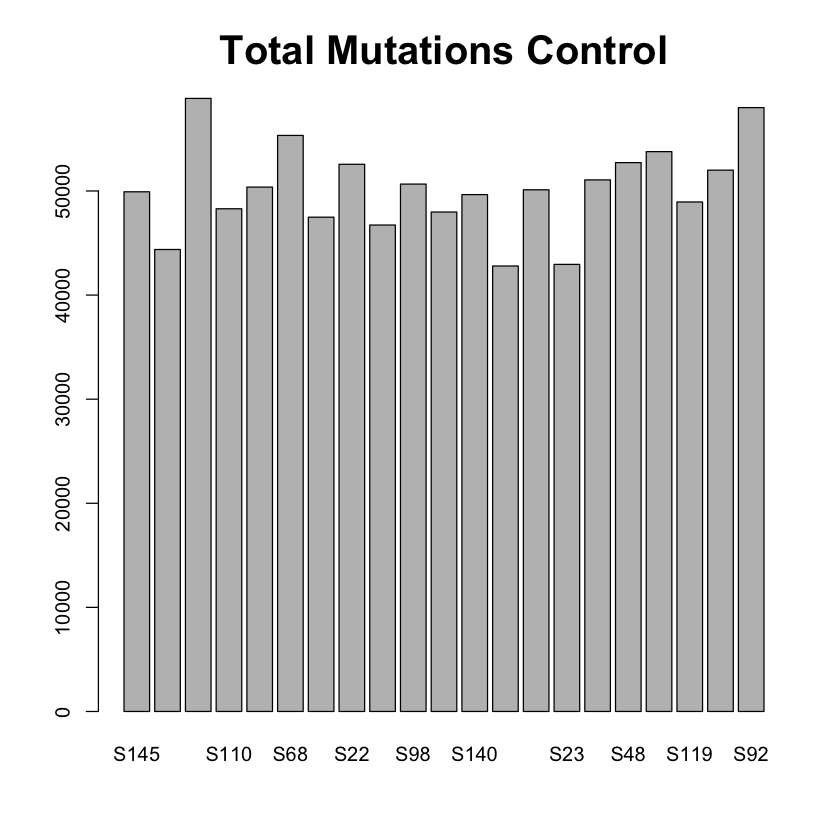

In [3]:
all_control_RA1 = retrieve_sample_names(sample_map, genotype = 'sgAAVS1', clone = "RA1")
mut_all_control_RA1 = subset_matrix_by_samples(mut_mat, all_control_RA1)
mut_all_control_RA1 = reorder_matrix_columns(mut_all_control_RA1, all_control_RA1)
total_muts_control_RA1 = colSums(mut_all_control_RA1)
barplot(total_muts_control_RA1, main = "Total Mutations Control", cex.main = 2)

### UBR4

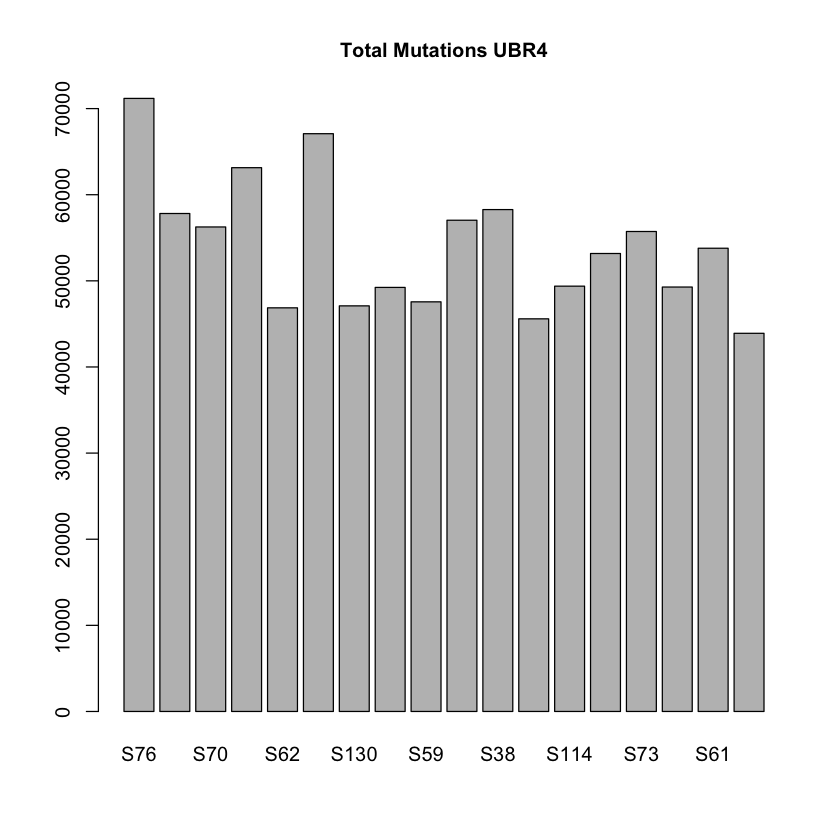

In [4]:
all_UBR4_RA1 <- retrieve_sample_names(sample_map, genotype = 'sgUBR4', clone = "RA1")
mut_all_UBR4_RA1 <- subset_matrix_by_samples(mut_mat, all_UBR4_RA1)
mut_all_UBR4_RA1 <- reorder_matrix_columns(mut_all_UBR4_RA1, all_UBR4_RA1)
total_muts_UBR4_RA1 <- colSums(mut_all_UBR4_RA1)
barplot(total_muts_UBR4_RA1, main = "Total Mutations UBR4", cex.main = 1)

### UBR5

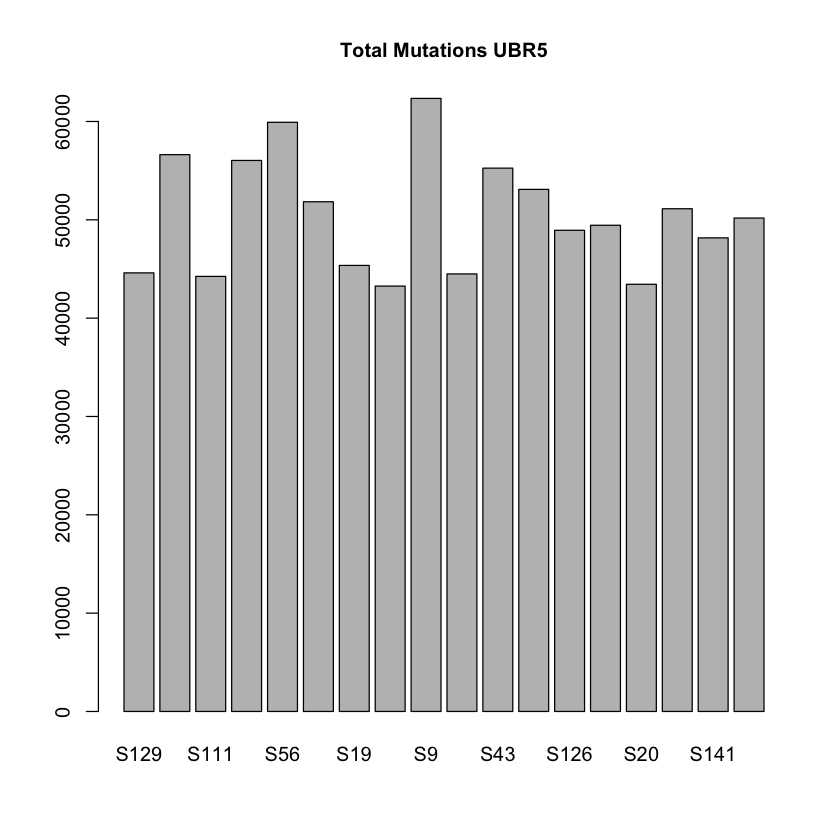

In [5]:
all_UBR5_RA1 <- retrieve_sample_names(sample_map, genotype = 'sgUBR5', clone = "RA1")
mut_all_UBR5_RA1 <- subset_matrix_by_samples(mut_mat, all_UBR5_RA1)
mut_all_UBR5_RA1 <- reorder_matrix_columns(mut_all_UBR5_RA1, all_UBR5_RA1)
total_muts_UBR5_RA1 <- colSums(mut_all_UBR5_RA1)
barplot(total_muts_UBR5_RA1, main = "Total Mutations UBR5", cex.main = 1)

### HUWE1

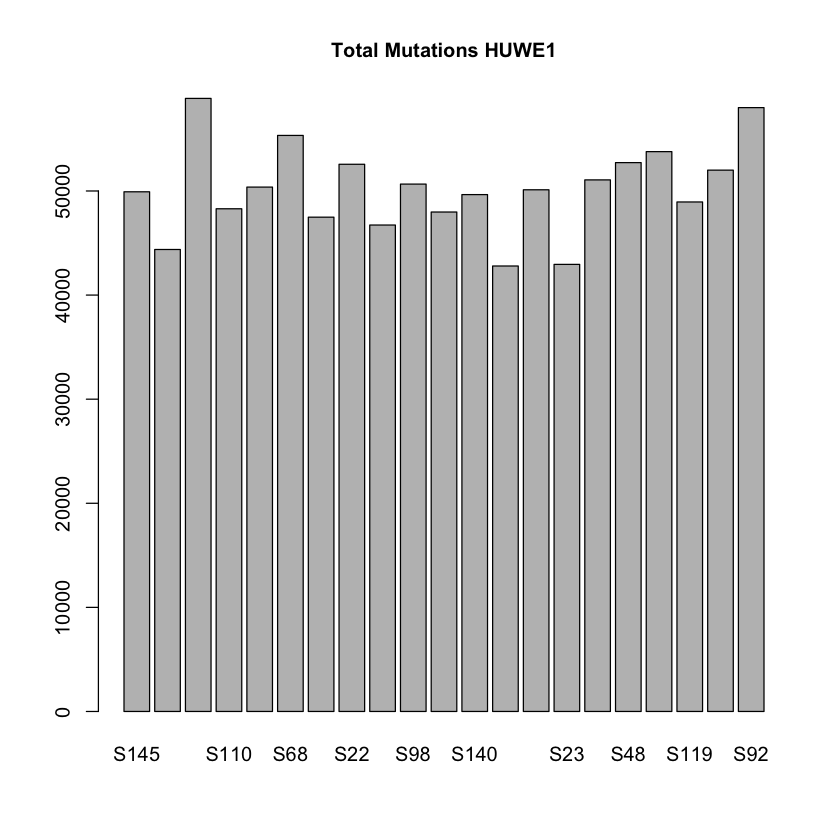

In [6]:
all_HUWE1_RA1 <- retrieve_sample_names(sample_map, genotype = 'sgAAVS1', clone = "RA1")
mut_all_HUWE1_RA1 <- subset_matrix_by_samples(mut_mat, all_HUWE1_RA1)
mut_all_HUWE1_RA1 <- reorder_matrix_columns(mut_all_HUWE1_RA1, all_HUWE1_RA1)
total_muts_HUWE1_RA1 <- colSums(mut_all_HUWE1_RA1)
barplot(total_muts_HUWE1_RA1, main = "Total Mutations HUWE1", cex.main = 1)

### Calculating Bootstrapped Background Profile from Day 3 Controls

In [7]:
#retrieve sample names
control_day3 = retrieve_sample_names(sample_map, genotype = 'sgAAVS1', culture_days = 'D03', clone = 'RA1')
#slice and reorder mutational matrix
mut_control_day3 = subset_matrix_by_samples(mut_mat, control_day3)
mut_control_day3 = reorder_matrix_columns(mut_control_day3, control_day3)
#rescale matrix to the sample with the lowest mutation count
mut_control_day3 = scale_matrix(mut_control_day3)

#bootstrap background baseline
#DAY 3 RA1
day3_bootstrapped_baseline = bootstrap_routine(mut_control_day3)
save(day3_bootstrapped_baseline, file = "10k_boot_control_day3.RDS")

#average boot results
day3_bootstrapped_baseline_mean = average_bootstrapped_samples(day3_bootstrapped_baseline)
#pull results into matrix
day3_bootstrapped_baseline_mean = round(hash_to_average_matrix(day3_bootstrapped_baseline_mean))
#average the averaged bootstrapped replicates into one profile
day3_bootstrapped_baseline_mean = round(rowMeans(day3_bootstrapped_baseline_mean))
#reshape to subtract from sample matrix of same dimensions
RA1_baseline = replicate(18, day3_bootstrapped_baseline_mean, simplify = 'matrix')

### Subtract Bootstrapped Background from Samples

### Control

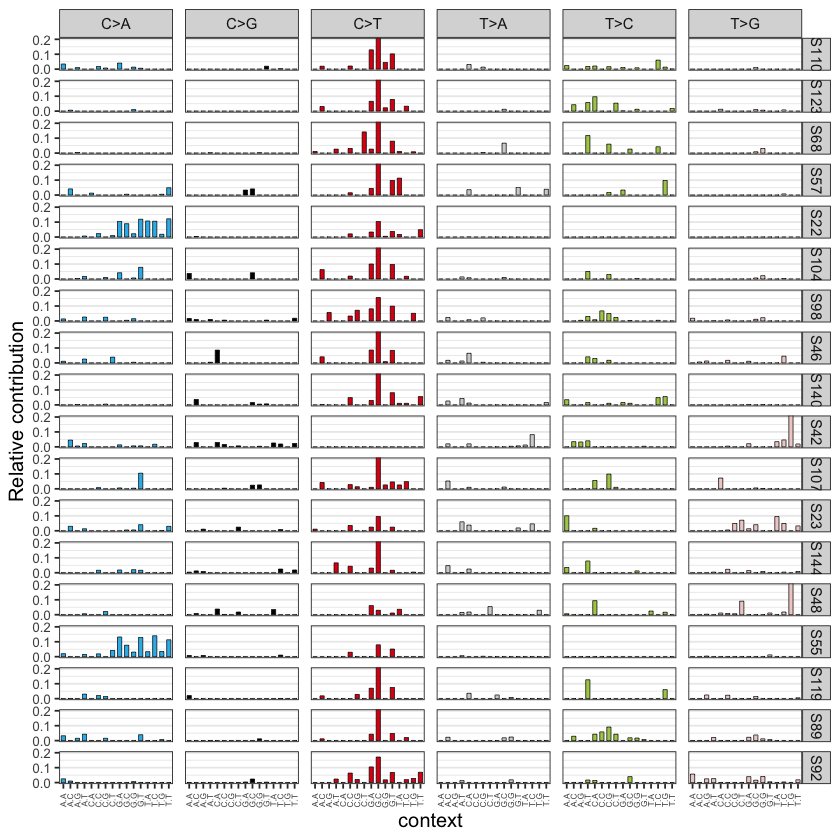

In [8]:
# correct control samples
#retrieve and order samples for controls
all_control <- retrieve_sample_names(sample_map, genotype = 'sgAAVS1', clone = "RA1")
#cut out day 3 samples that were already used in bootstrappping
all_control = all_control[-c(1:3)]
#retrieve mutation data
mut_all_control <- subset_matrix_by_samples(mut_mat, all_control)
mut_all_control <- reorder_matrix_columns(mut_all_control, all_control)


#rescale mutational matrix for controls
mut_all_control_RA1_rescaled <- scale_matrix(mut_all_control)
#correct for bootstrapped baseline
control_RA1_corrected <- mut_all_control_RA1_rescaled - RA1_baseline
control_RA1_corrected <- pmax(control_RA1_corrected, 0)

plot_96_profile(control_RA1_corrected)

### E3 Ligase Knockouts

#### UBR4

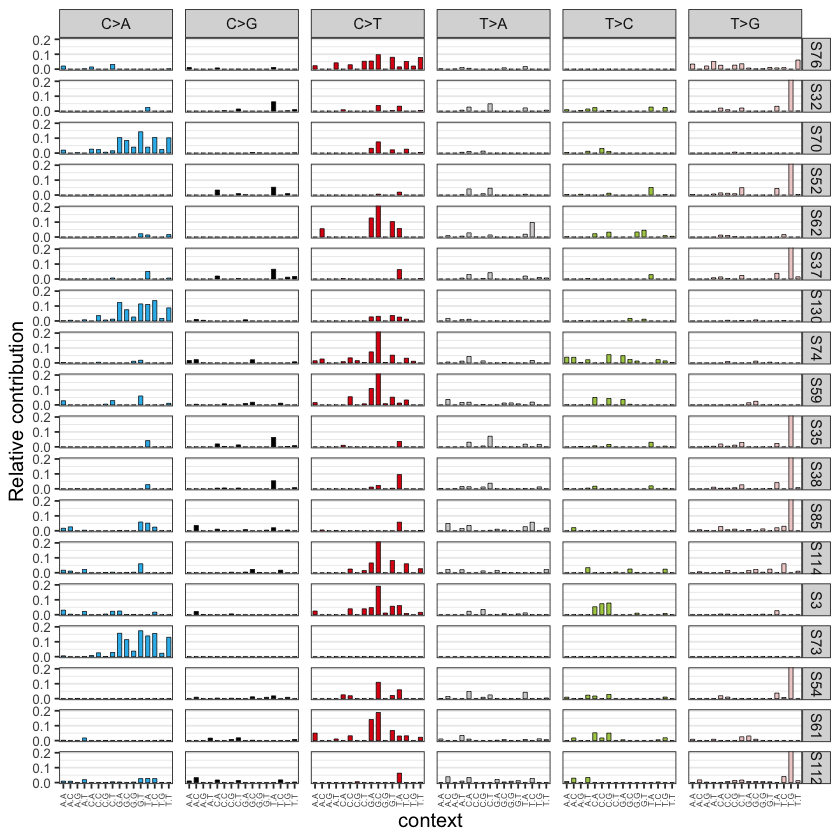

In [9]:
#retrieve and order samples for UBR4
all_UBR4_RA1 <- retrieve_sample_names(sample_map, genotype = 'sgUBR4', clone = "RA1")
mut_all_UBR4_RA1 <- subset_matrix_by_samples(mut_mat, all_UBR4_RA1)
mut_all_UBR4_RA1 <- reorder_matrix_columns(mut_all_UBR4_RA1, all_UBR4_RA1)

#rescale mutational matrix for UBR4
mut_all_UBR4_RA1_rescaled <- scale_matrix(mut_all_UBR4_RA1)
#correct for bootstrapped baseline
UBR4_RA1_corrected <- mut_all_UBR4_RA1_rescaled - RA1_baseline
UBR4_RA1_corrected <- pmax(UBR4_RA1_corrected, 0)


plot_96_profile(UBR4_RA1_corrected)

#### UBR5

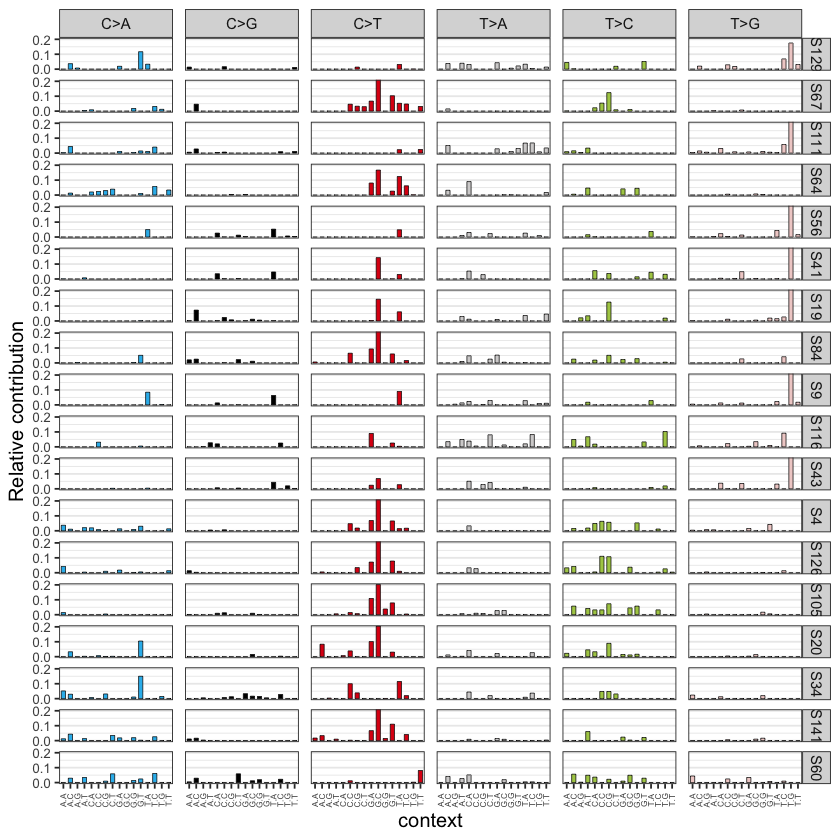

In [10]:
#retrieve and order samples for UBR5
all_UBR5_RA1 <- retrieve_sample_names(sample_map, genotype = 'sgUBR5', clone = "RA1")
mut_all_UBR5_RA1 <- subset_matrix_by_samples(mut_mat, all_UBR5_RA1)
mut_all_UBR5_RA1 <- reorder_matrix_columns(mut_all_UBR5_RA1, all_UBR5_RA1)

#rescale mutational matrix for UBR5
mut_all_UBR5_RA1_rescaled <- scale_matrix(mut_all_UBR5_RA1)
#correct for bootstrapped baseline
UBR5_RA1_corrected <- mut_all_UBR5_RA1_rescaled - RA1_baseline
UBR5_RA1_corrected <- pmax(UBR5_RA1_corrected, 0)

plot_96_profile(UBR5_RA1_corrected)

#### HUWE1

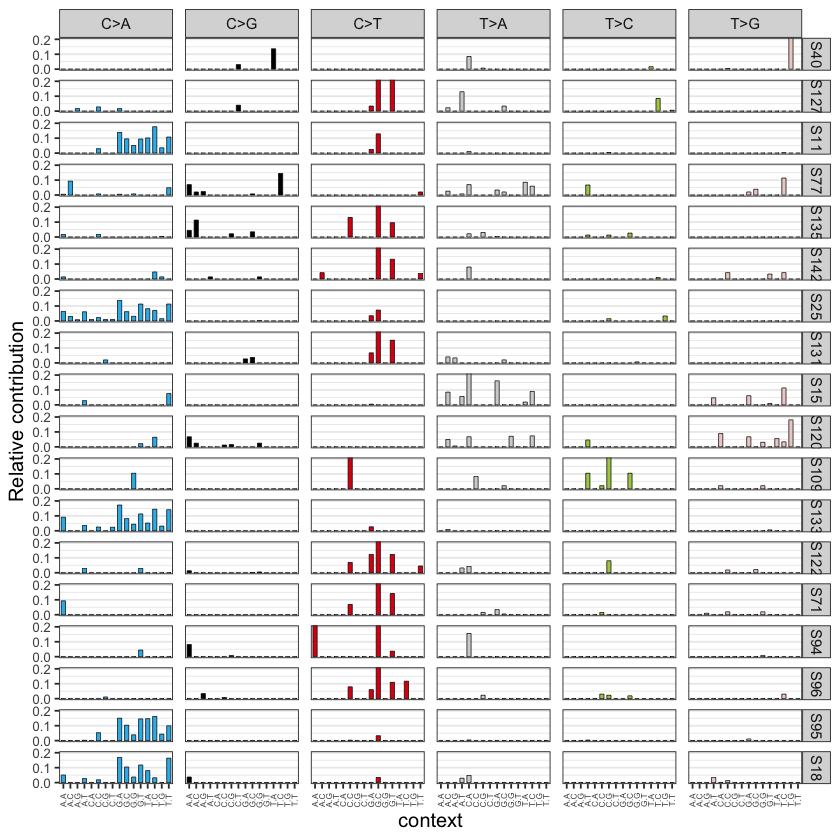

In [11]:
#retrieve and order samples
all_HUWE1_RA1 <- retrieve_sample_names(sample_map, genotype = 'sgHUWE1', clone = "RA1")
mut_all_HUWE1_RA1 <- subset_matrix_by_samples(mut_mat, all_HUWE1_RA1)
mut_all_HUWE1_RA1 <- reorder_matrix_columns(mut_all_HUWE1_RA1, all_HUWE1_RA1)

#rescale mutational matrix
mut_all_HUWE1_RA1_rescaled = scale_matrix(mut_all_HUWE1_RA1)
#correct for bootstrapped baseline
HUWE1_RA1_corrected = mut_all_HUWE1_RA1_rescaled - RA1_baseline
HUWE1_RA1_corrected = pmax(HUWE1_RA1_corrected, 0)

plot_96_profile(HUWE1_RA1_corrected)

# Refitting After Background Correction

#### control

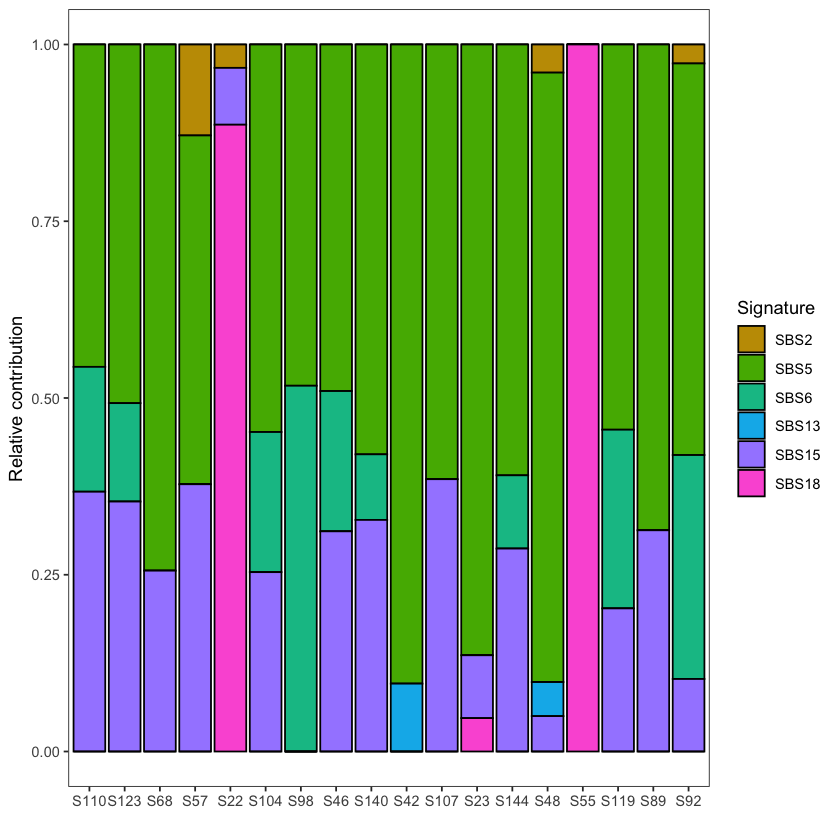

In [12]:
#signature catalog
prior_knowledge_subset = signatures[,c(1,2,5,6,19,21,25)]

#refitting
control_best_subset_refit = fit_to_signatures_strict(control_RA1_corrected, prior_knowledge_subset, max_delta = 0.001, method = "best_subset")
control_result = control_best_subset_refit$fit_res$contribution

#plot
plot_contribution(control_result,
  coord_flip = FALSE,
  mode = "relative"
)

#### UBR4

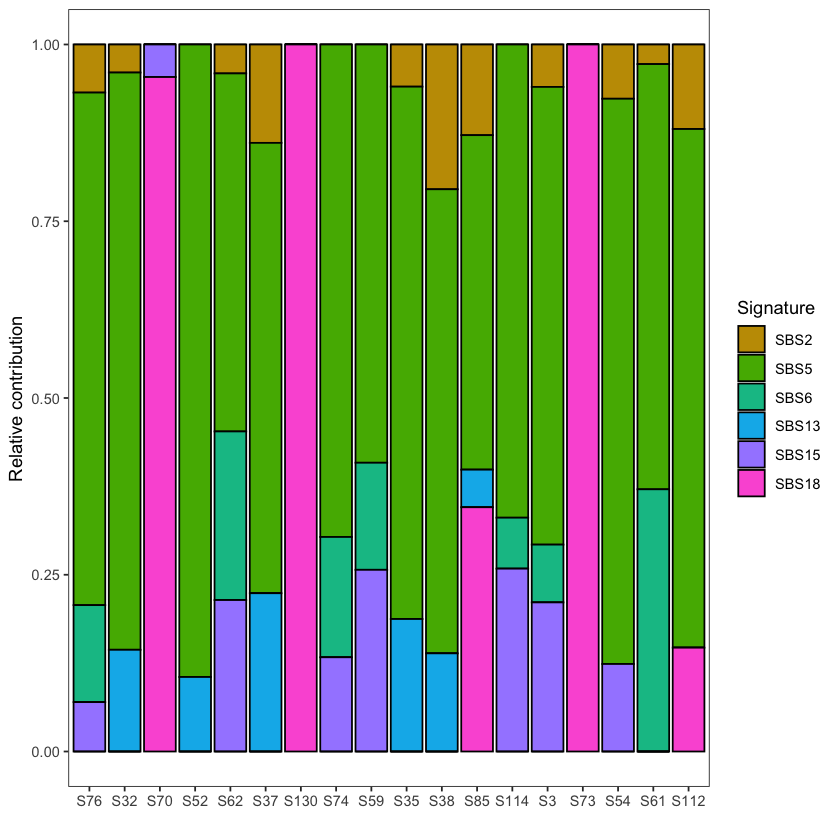

In [13]:
#signature catalog
prior_knowledge_subset = signatures[,c(1,2,5,6,19,21,25)]

#refitting
RA1_UBR4_best_subset_refit = fit_to_signatures_strict(UBR4_RA1_corrected, prior_knowledge_subset, max_delta = 0.001, method = "best_subset")
RA1_UBR4_result = RA1_UBR4_best_subset_refit$fit_res$contribution

#plot
plot_contribution(RA1_UBR4_result,
  coord_flip = FALSE,
  mode = "relative"
)

#### UBR5

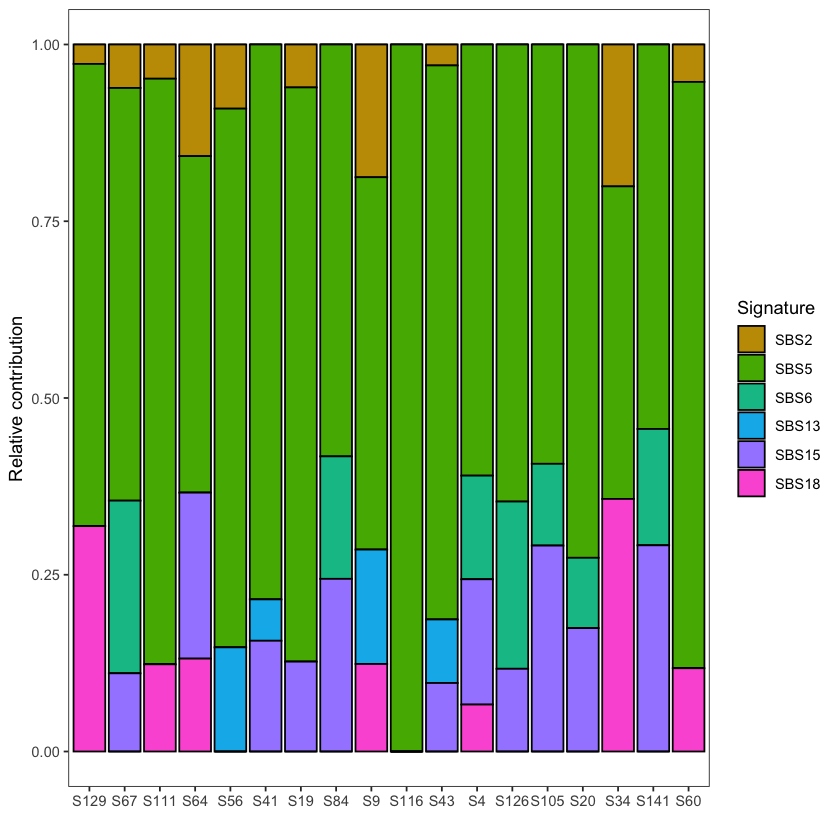

In [14]:
# signature catalog
prior_knowledge_subset = signatures[,c(1,2,5,6,19,21,25)]

#refitting
RA1_UBR5_best_subset_refit = fit_to_signatures_strict(UBR5_RA1_corrected, prior_knowledge_subset, max_delta = 0.001, method = "best_subset")
RA1_UBR5_result = RA1_UBR5_best_subset_refit$fit_res$contribution

#plot
plot_contribution(RA1_UBR5_result,
  coord_flip = FALSE,
  mode = "relative"
)

#### HUWE1

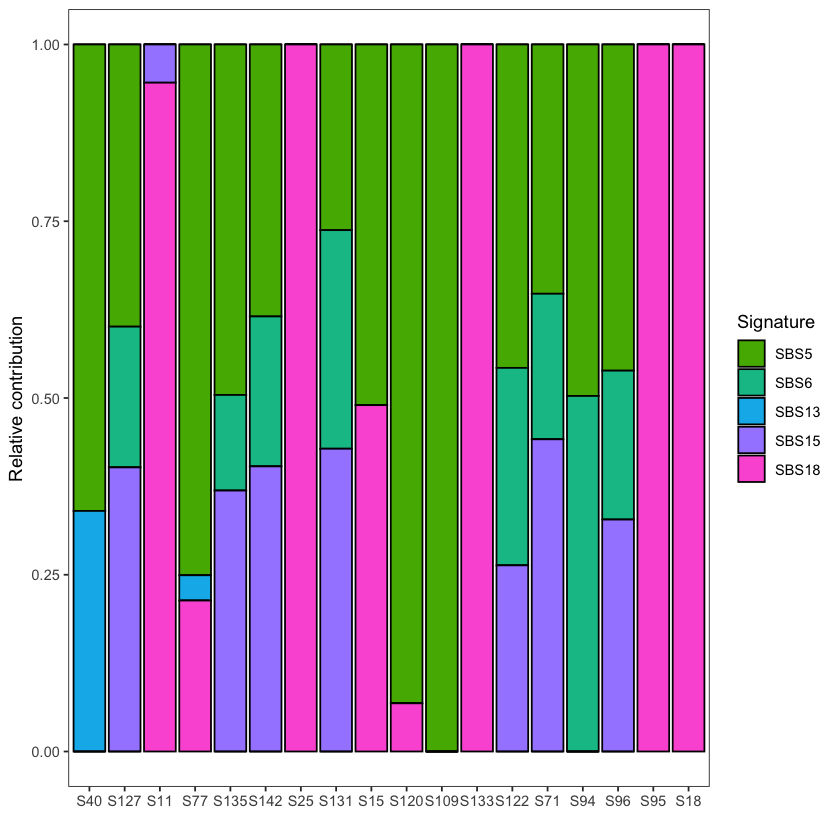

In [15]:
#signature catalog
prior_knowledge_subset = signatures[,c(1,2,5,6,19,21,25)]

#refitting
RA1_HUWE1_best_subset_refit = fit_to_signatures_strict(HUWE1_RA1_corrected, prior_knowledge_subset, max_delta = 0.001, method = "best_subset")
RA1_HUWE1_result = RA1_HUWE1_best_subset_refit$fit_res$contribution

#plot
plot_contribution(RA1_HUWE1_result,
  coord_flip = FALSE,
  mode = "relative"
)

## Export data

#### mutation counts after background correction

In [16]:
write.csv(control_RA1_corrected, file = 'control_corrected.csv', row.names = T)
write.csv(HUWE1_RA1_corrected, file = 'HUWE1_corrected.csv', row.names = T)
write.csv(UBR4_RA1_corrected, file = 'UBR4_corrected.csv', row.names = T)
write.csv(UBR5_RA1_corrected, file = 'UBR5_corrected.csv', row.names = T)

all_RA1_corrected = cbind(control_RA1_corrected, HUWE1_RA1_corrected, UBR4_RA1_corrected, UBR5_RA1_corrected)

write.csv(all_RA1_corrected, file = 'all_corrected.csv', row.names = T)

#### mutation counts - refitting results

In [17]:
all_refitting = cbind(control_result, RA1_HUWE1_result, RA1_UBR4_result, RA1_UBR5_result)

write.csv(all_refitting, file = 'all_refitting.csv', row.names = T)